# Compare SARSA and Q-learning on Cliff walking task
Useful links:
* https://towardsdatascience.com/reinforcement-learning-cliff-walking-implementation-e40ce98418d4
* https://github.com/ShangtongZhang/reinforcement-learning-an-introduction/blob/master/chapter06/cliff_walking.py
* https://github.com/prabodhhere/cliffwalker/blob/master/cliffwalker.ipynb
* Reinforcement Learning: An Introduction R. Sutton, and A. Barto. The MIT Press, Second edition, (2018)
* RL.ppt

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Create environment

In [105]:
class world():
    def __init__(self):
        self.height = 4
        self.width = 12
        
        self.posX = 0
        self.posY = self.height-1
        
        self.endX = self.width-1
        self.endY = self.height-1
        
        self.actions = np.array(["left", "right", "up", "down"])
        self.stateCount = self.height*self.width
        self.actionCount = len(self.actions)
        self.rewards = self.fill_rewards_map()
    
    def fill_rewards_map(self):
        rewards = np.zeros((self.height, self.width))-1
        rewards[self.height-1,1:self.width-1]=-100
        return rewards
    
    def reset(self):
        self.posX = 0
        self.posY = self.height-1
        self.done = False
        self.cliff = False
    
    def show_state(self):
        clear_output()
        fig, ax = plt.subplots(figsize = (4*2,12*2))
        ax.text(self.posX, self.posY, "x", va='center', ha='center', fontsize=24)
        ax.text(0, self.height-1, "S", va='center', ha='center', fontsize=24)
        ax.text(self.width-1, self.height-1, "G", va='center', ha='center', fontsize=24)
        min_val, max_val, diff = 0, np.max(np.shape(self.rewards)), 1
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks(np.arange(min_val-diff/2, max_val-diff/2))
        ax.set_yticks(np.arange(min_val-diff/2, max_val-diff/2))
        ax.imshow(self.rewards)
        ax.grid()
        plt.show()
        time.sleep(0.25)
        
    def step(self, action):
        if action == "left":
            self.posX = self.posX-1 if self.posX > 0 else self.posX
        if action == "right":
            self.posX = self.posX+1 if self.posX < self.width - 1 else self.posX
        if action == "up":
            self.posY = self.posY-1 if self.posY > 0 else self.posY
        if action == "down":
            self.posY = self.posY+1 if self.posY < self.height - 1 else self.posY
        if ((action == "down" and self.posY == 2 and 1 <= self.posY <= 10) or (action == "right" and (self.posX == 0 and self.posY == self.height-1))):
            self.posY, self.posX = self.height-1, 0

        done = self.posX == self.endX and self.posY == self.endY
        cliff = self.posX in range(1,self.width-1) and self.posY == self.height-1
        reward = self.rewards[self.posY, self.posX]
        return self.posY, self.posX, reward, done, cliff

### Play game (episode) manual control for environment test

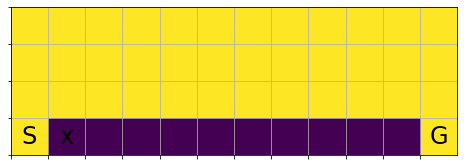

cummulative_reward =-100.0


In [90]:
w = world()
cummulative_reward = 0
done = False
cliff = False
w.show_state()
while True:
    print(f"Action idx 0, 1, 2, 3 -> left, right, up, down")
    action_idx = int(input("Insert action no:"))
    action = w.actions[action_idx]
    y, x, cur_reward, done, cliff = w.step(action)
    print(f"y_next = {y}") 
    print(f"x_next = {x}") 
    cummulative_reward += cur_reward
    w.show_state()
    if done or cliff:
        w.reset()
        break
print(f"cummulative_reward ={cummulative_reward}")
del w

## 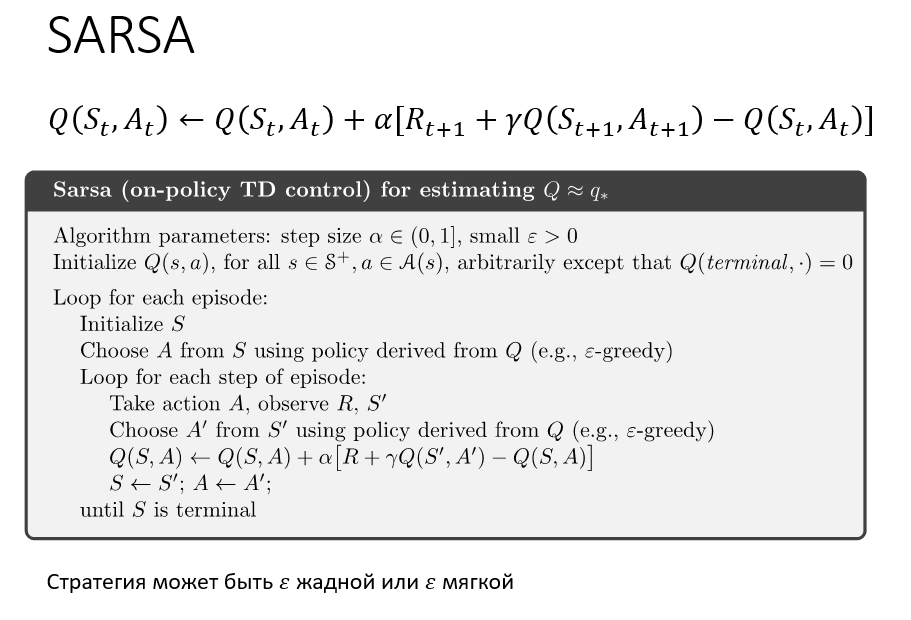

In [5]:
def e_greedy_action(Q, w, epsilon):
    greedy_action = w.actions[np.argmax(Q[w.posY, w.posX,:])]
    #print(greedy_action)
    random_action = w.actions[np.random.randint(0, w.actionCount-1)]
    action = np.random.choice([greedy_action, random_action], p=[1-epsilon, epsilon])
    idx = np.where(w.actions == action)
    return action, idx[0][0]

In [24]:
w = world()

runs = 30  # independent runs
num_episodes = 500
alpha = 0.9 # learning rate (0, 1]
epsilon = 0.1 # for e-greedy
gamma = 1 # discount rate

reward_per_episode = np.zeros(num_episodes)
for r in range(runs):
    Q = np.zeros((w.height, w.width, w.actionCount))
    for i in range(num_episodes):
        action, idx_action = e_greedy_action(Q, w, epsilon)
        while True:
            S_Y, S_X = w.posY, w.posX #S          
            S_Y_new, S_X_new, cur_reward, done, cliff = w.step(action) #AR
            reward_per_episode[i] += cur_reward
            next_action, idx_next_action = e_greedy_action(Q, w, epsilon)
            Q[S_Y, S_X, idx_action] += alpha*(cur_reward +
                                              gamma*Q[S_Y_new, S_X_new, idx_next_action]
                                              - Q[S_Y, S_X, idx_action])
            w.posY, w.posX = S_Y_new, S_X_new #S
            action = next_action #A
            idx_action = idx_next_action
            if done or cliff:
                w.reset()
                break

reward_per_episode /= runs
del w

## Plot SARSA rewards

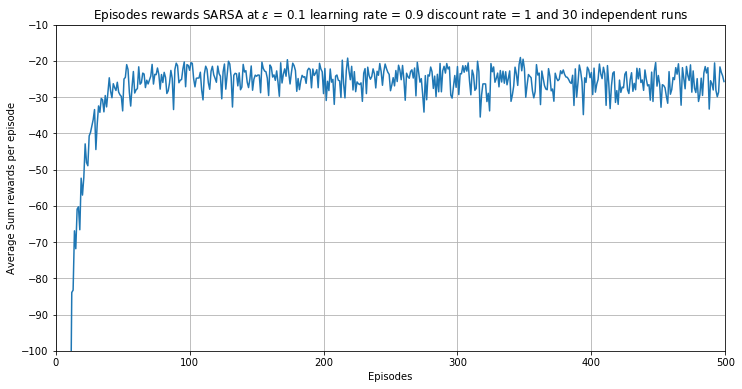

In [25]:
figsize=(12, 6)
plt.figure(figsize=figsize)
title = f"Episodes rewards SARSA at $\epsilon$ = {epsilon} learning rate = {alpha} discount rate = {gamma} and {runs} independent runs"
plt.title(title)
rew_plot = plt.plot(reward_per_episode)
plt.grid(True)
plt.ylabel("Average Sum rewards per episode")
plt.xlabel("Episodes")
plt.xlim([0, 500])
plt.ylim([-100, -10])
plt.show()

## Plot SARSA path

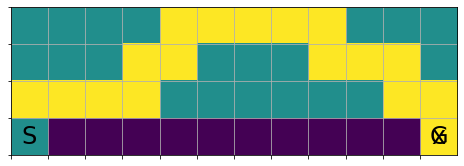

cummulative_reward =-17.0


In [26]:
w = world()
cummulative_reward = 0
done = False
while True:
    action = w.actions[np.argmax(Q[w.posY, w.posX,:])]
    _, _, cur_reward, done, cliff = w.step(action)
    w.rewards[w.posY, w.posX]=100
    cummulative_reward += cur_reward
    w.show_state()
    if done or cliff:
        w.reset()
        break
print(f"cummulative_reward ={cummulative_reward}")
del w

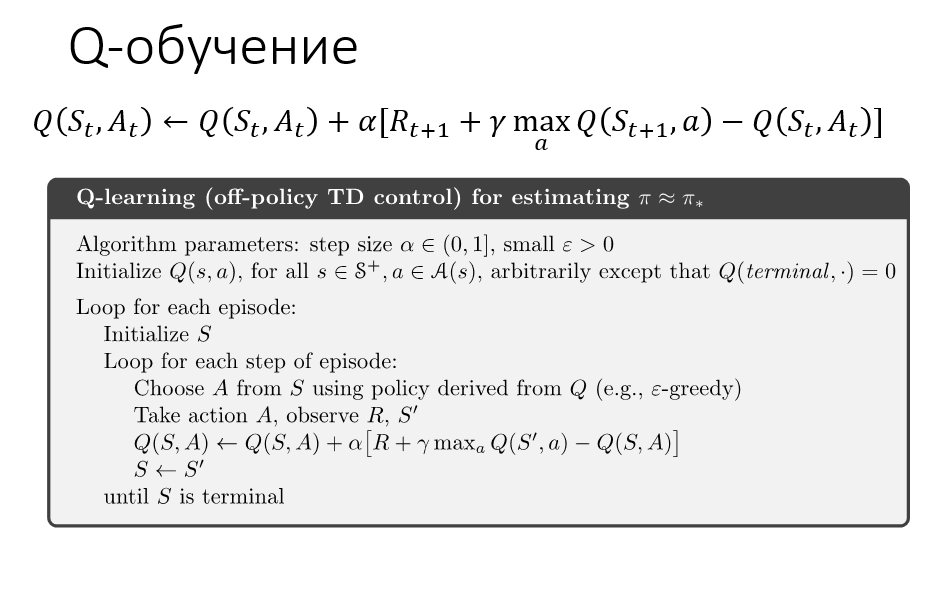

In [120]:
w = world()

runs = 30 # independent runs
num_episodes = 500
alpha = 0.9 # learning rate (0, 1]
epsilon = 0.15 # for e-greedy
gamma = 1 # discount rate

reward_per_episode_Q = np.zeros(num_episodes)
for r in range(runs):
    Q_ql = np.zeros((w.height, w.width, w.actionCount))
    for i in range(num_episodes):
        done = False
        w.posY, w.posX = 3, 0
        S_Y, S_X = 3, 0
        cur_reward = 0
        while not done:
            S_Y, S_X = w.posY, w.posX
            action, idx_action = e_greedy_action(Q_ql, w, epsilon)
            S_Y_new, S_X_new, cur_reward, done, cliff = w.step(action)
            reward_per_episode_Q[i] += cur_reward
            max_Q = np.max(Q_ql[S_Y_new, S_X_new, :])
            Q_ql[S_Y, S_X, idx_action] += alpha*(cur_reward + gamma*max_Q - Q_ql[S_Y, S_X, idx_action])
            w.posY, w.posX = S_Y_new, S_X_new
            
reward_per_episode_Q /= runs
del w

### Plot Q-learning rewards

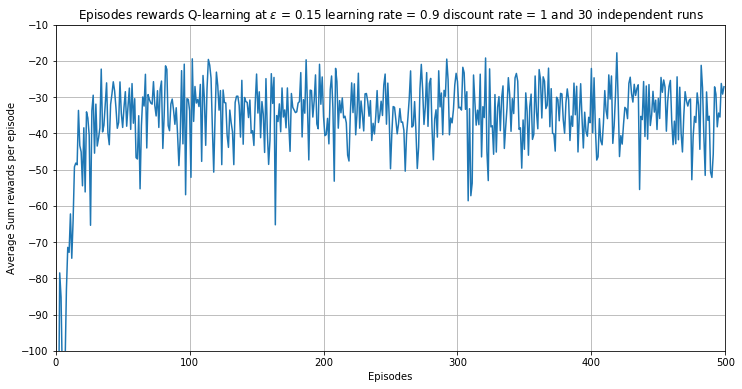

In [123]:
figsize=(12, 6)
plt.figure(figsize=figsize)
title = f"Episodes rewards Q-learning at $\epsilon$ = {epsilon} learning rate = {alpha} discount rate = {gamma} and {runs} independent runs"
plt.title(title)
rew_plot = plt.plot(reward_per_episode_Q)
plt.grid(True)
plt.ylabel("Average Sum rewards per episode")
plt.xlabel("Episodes")
plt.xlim([0, 500])
plt.ylim([-100, -10])
plt.show()

## Plot Q-learning Path

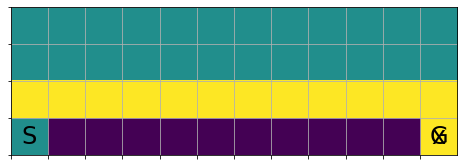

cummulative_reward =-13.0


In [118]:
w = world()
cummulative_reward = 0
done = False
while True:
    action = w.actions[np.argmax(Q_ql[w.posY, w.posX,:])]
    _, _, cur_reward, done, cliff = w.step(action)
    w.rewards[w.posY, w.posX]=100
    cummulative_reward += cur_reward
    w.show_state()
    if done or cliff:
        w.reset()
        break
print(f"cummulative_reward ={cummulative_reward}")
del w

## Plot SARSA and Q-learnig rewards

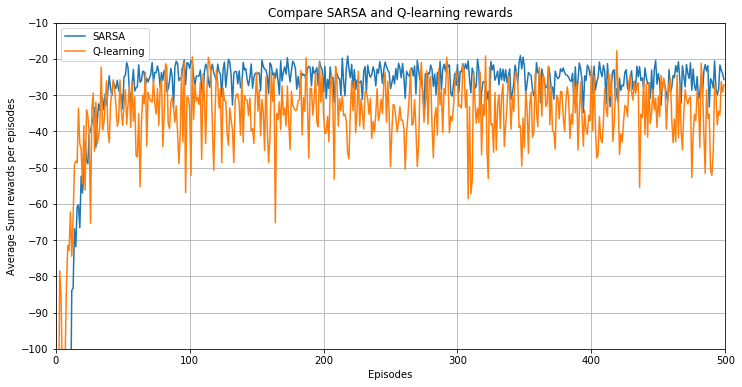

In [122]:
figsize=(12, 6)
plt.figure(figsize=figsize)
title = f"Compare SARSA and Q-learning rewards"
plt.title(title)
rew_plot_s = plt.plot(reward_per_episode, label='SARSA')
rew_plot_q = plt.plot(reward_per_episode_Q, label='Q-learning')
plt.grid(True)
plt.legend()
plt.ylabel("Average Sum rewards per episodes")
plt.xlabel("Episodes")
plt.xlim([0, 500])
plt.ylim([-100, -10])
plt.show()